# Ordinary linear regression with R and Stan

Linear regression models are one of the most simple forms of relationship that can be proposed between measured data. They often serve as an introduction to statistical learning ([see this book as a good example](https://faculty.marshall.usc.edu/gareth-james/ISL/)) because they offer a simple framework to demonstrate the important steps that a data analyst should follow: model selection, hypothesis testing, validation...

Under some strong hypotheses, the energy balance of a building can be approximated by linear functions. They however have several limitations: they cannot represent non-linear phenomena, such as radiative heat exchange between walls; they don't allow identifying the parameters driving dynamical phenomena; they impose a fixed structure to the energy balance equation.

Despite these limitations, linear regression models can however be very useful as a first insight into the heat balance of a building: they allow a quick assessment of which types of measurements have an impact on the global balance and guide the choice of more detailed models. Moreover, if a large enough amount of data is available, the estimates of some coefficients such as the HLC often turn out to be quite reliable.

In the following, we show a practical application of linear regression to the identification of the important phenomena that influence the energy use in a house.


## The data

The data used in this example was published by the Oak Ridge National Laboratory, Building Technologies Research and Integration Center (USA). It contains end use breakdowns of energy use and various indoor environmental conditions collected at the Campbell Creek Research House #3, at a 15 minute time stamp. The data availability ranges from 10/1/2013 to 9/30/2014. It is available for download at this address:

https://openei.org/datasets/dataset/ornl-research-house-3

This dataset was chosen in this example for the diversity and duration of the available measurements.

Before taking a look at the data, let us start with some imports.

In [1]:
library(tidyverse)
library(lubridate)

df <- read_csv("data/linearregression.csv") %>% transform(TIMESTAMP = ymd(TIMESTAMP))
head(df)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.2.0
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date

Parsed with column specification:
cols(
  TIMESTAMP = col_date(format = ""),
  e_hp = col_double(),
  e_dhw = col_double(),
  e_fan = col_double(),
  e_other = col_double(),
  ti = col_double(),
  tg = col_double(),
  ts = col_double(),
  te = col_double(),
  i_sol = col_double(),
  wind_speed = col_double()
)


TIMESTAMP,e_hp,e_dhw,e_fan,e_other,ti,tg,ts,te,i_sol,wind_speed
2013-11-01,22.76562,36.42188,9.866156,227.1703,24.08979,19.50503,12.687269,17.138426,125.65962,0.9309792
2013-11-02,22.94271,32.01042,9.985406,232.4833,22.71608,18.40336,8.639988,10.260706,90.86609,0.6845729
2013-11-03,23.07250,28.19500,9.977400,226.7301,21.18138,17.36883,10.676611,7.348556,113.59297,0.9137600
2013-11-04,49.60208,58.77083,10.032833,228.3963,20.66780,16.77118,11.524884,8.462442,116.15323,0.3336250
2013-11-05,23.09896,57.51042,10.008042,301.6326,20.97978,16.91042,11.532292,10.836343,108.98073,0.3369687
2013-11-06,23.00521,55.95312,10.292667,280.0146,21.40096,17.36753,13.797685,14.630382,87.00867,0.3273958


This dataframe has quite a lot of features, as shown by the output of the `head()` method. The house is heated and cooled by a heat pump, and most energy uses (plugs, appliances, hot water production...) are broken down and measured separately. Temperatures, relative humidities are also available in several locations. We are going to use the **energy use of the heat pump** `e_hp` as the output variable of linear regression models, and try to explain it with the other available variables. The data is already averaged on daily time steps.

## The model

Since we have time series data, the most informative way to use it would be a time series model, typically of the family of autoregressive models with exogenous variables, or an RC state-space model. This would allow us to identify the influences on the dynamics of the output variable.

The present notebook however proposes a more simple, stationary balance equation. This is the full model equation that we are going to consider, supposing that the heat pump is operating in winter conditions:

$$ \Phi_{hp} + \Phi_s + \Phi_v + \Phi_{inf} = H \, (T_i-T_e) + H_g \, (T_i-T_g) $$

On the left side are the heat sources $\Phi$ (W), some of which may be negative:
* $\Phi_{hp} \propto e_{hp}$ is the heating power provided by the heat pump to the indoor space. It is proportional to the energy reading $e_{hp}$ (Wh), which we will use as output variable, and to the time step size and the COP of the heat pump, supposed constant.
* $\Phi_s \propto I_{sol}$ are the solar gains, supposed proportional to the measured outdoor solar irradiance $I_{sol}$ (W/m$^2$) and an unknown constant solar aperture coefficient $A_s$ (m$^2$).
* $\Phi_v = \dot{m} \, c_p \, (T_s-T_i)$ is the ventilation heat input, with a ventilation supply rate $\dot{m}$ and supply temperature $T_s$, which is measured (the house has a mechanical ventilation system with heat recovery)
* $\Phi_{inf} \propto V_{ws} (T_e-T_i)$ is the heat input from air infiltration. We suppose it is proportional to the wind speed $V_{ws}$ and the outdoor-indoor temperature difference.

On the right side are two terms of heat loss through the envelope:
* $H \, (T_i-T_e)$ is the direct heat loss from the heated space at temperature $T_i$ and the outdoor at $T_e$
* $H_g \, (T_i-T_g)$ is the heat loss through the partition wall between the heated space and an unheated garage at $T_g$.

Linear regression should allow us to identify the coefficients of each term, supposing that they have enough variability and influence on the output $\Phi_{hp}$. The outcome of the regression method will let us judge if this hypothesis is appropriate.

## Training

### First simple model

Before fitting the full model shown above, let us try one with a single explanatory variable, which we assume has the most influence on the energy use of the heat pump: the heat transmission through the envelope.

$$ e_{hp} = \theta_1 (T_i-T_e)$$

where the $\theta_1$ parameter includes the heat loss coefficient $H$, the COP of the heat pump and the time step size. Since the COP is unknown, we won't be able to estimate $H$. This is fine, as the point of the exercise is mostly to identify influential features. $\theta_0$ is a constant intercept.

First, we need to add $T_i-T_e$ as a new column of the dataframe. Then we use this column as the only explanatory variable in R's linear regression function. An intercept is included by default: the `+ 0` part of the expression is used here to remove it.

In [2]:
df <- df %>% mutate(tite = ti - te)
lm1.fit = lm(e_hp ~ tite + 0, data=df)
summary(lm1.fit)


Call:
lm(formula = e_hp ~ tite + 0, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-166.91  -86.02  -49.12   -8.52  439.43 

Coefficients:
     Estimate Std. Error t value Pr(>|t|)    
tite  13.2377     0.5113   25.89   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 109.7 on 150 degrees of freedom
Multiple R-squared:  0.8171,	Adjusted R-squared:  0.8159 
F-statistic: 670.2 on 1 and 150 DF,  p-value: < 2.2e-16


The table displays the results of the linear regression fitting by ordinary least squares. Some indicators are useful to judge if the model sufficiently explains the output data, or if some input features are redundant.

* The t-statistic and p-value indicate whether an input has a significant influence on the input: `P>|t|` should be close to zero, meaning that the null hypothesis should be rejected. In this case, the only input is relevant.
* R-squared measures the goodness of fit of the regression. 0.817 is a rather low value, which hints that the output should be explained by additional features in the model.
* Other values like AIC, BIC or the Durbin-Watson statistic can be calculated. DW indicates whether there is autocorrelation of the residuals.

The output variable is not well explained solely by a linear function of $(T_i-T_e)$, and the model should be improved. We can confirm this with a graph of the confidence interval and prediction interval of the fitted linear model:

Warning message in predict.lm(lm1.fit, interval = "prediction"):
“predictions on current data refer to _future_ responses
”

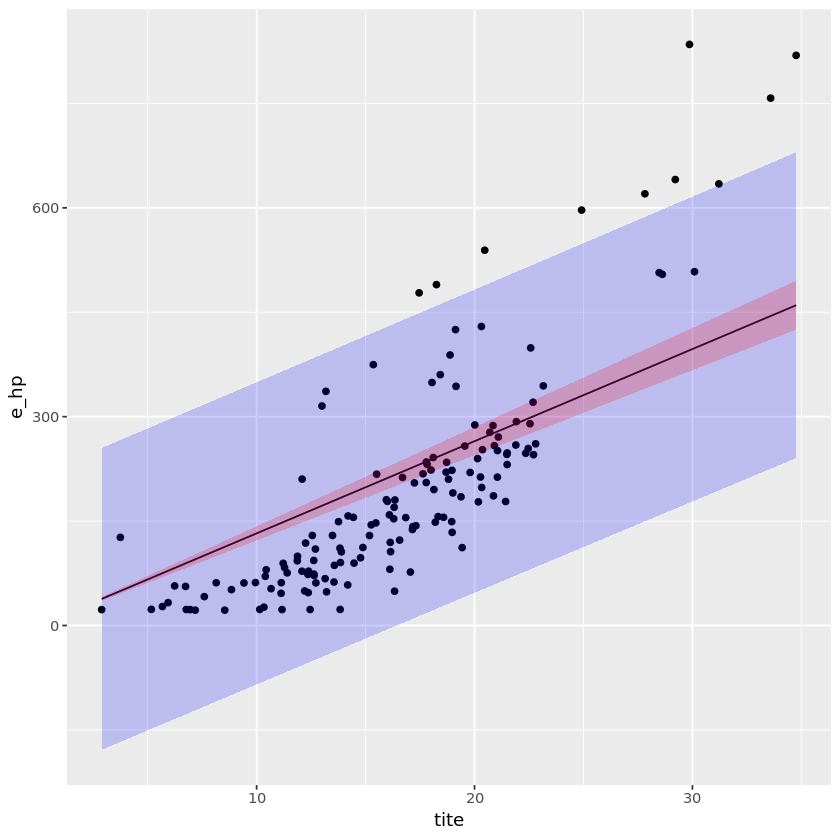

In [3]:
conf.int = as.data.frame( predict(lm1.fit, interval="confidence") )
pred.int = as.data.frame( predict(lm1.fit, interval="prediction") )

ggplot() +
  geom_point(data = df, aes(tite, e_hp)) +
  geom_line(aes(x=df$tite, y=pred.int$fit)) +
  geom_ribbon(aes(x=df$tite, ymin=pred.int$lwr, ymax=pred.int$upr), alpha=0.2, fill='blue') +
  geom_ribbon(aes(x=df$tite, ymin=conf.int$lwr, ymax=conf.int$upr), alpha=0.2, fill='red')

### Complete model

Now we can try a more complete linear regression model, which matches the full model described earlier

$$ e_{hp} = a_1 (T_i-T_e) + a_2 (T_i-T_g) + a_3 I_{sol} + a_4 (T_i-T_s) + a_4 V_{ws}(T_i-T_e) $$

This model has five input variables. There are some more variables that need to be added to the dataframe to account for:

* The heat loss towards the unheated garage at temperature $T_g$
* The ventilation heat supply $\Phi_v \propto (T_s-T_i)$
* The air infiltration heat loss $\Phi_{inf} \propto V_{ws} (T_e-T_i)$

In [4]:
df <- df %>% mutate(titg = ti - tg,
                    tits = ti - ts,
                    vtite = wind_speed * (ti-te))
lm2.fit = lm(e_hp ~ tite + titg + i_sol + tits + vtite + 0, data=df)
summary(lm2.fit)


Call:
lm(formula = e_hp ~ tite + titg + i_sol + tits + vtite + 0, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-211.35  -80.19  -28.12   22.40  323.54 

Coefficients:
       Estimate Std. Error t value Pr(>|t|)    
tite  22.134160   2.190009  10.107   <2e-16 ***
titg   1.673180   5.849859   0.286   0.7753    
i_sol -0.373744   0.198848  -1.880   0.0622 .  
tits  -8.479184   3.621594  -2.341   0.0206 *  
vtite  0.002483   0.735571   0.003   0.9973    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 95.34 on 146 degrees of freedom
Multiple R-squared:  0.8656,	Adjusted R-squared:  0.861 
F-statistic:   188 on 5 and 146 DF,  p-value: < 2.2e-16


The R-squared has improved, and the AIC and BIC criteria have decreased: this model seems to be a better choice than the first one.

Two input variables however have a very high $p$-value: $(T_i-T_g)$ and $V_{ws}(T_i-T_e)$. This suggests that the heat transfer between the heated space and the garage, and the wind, have little impact on the energy consumption of the heat pump. We can simplify the model by removing these two features:

In [5]:
lm3.fit = lm(e_hp ~ tite + i_sol + tits + 0, data=df)
summary(lm3.fit)


Call:
lm(formula = e_hp ~ tite + i_sol + tits + 0, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-209.27  -81.17  -28.52   26.60  323.60 

Coefficients:
      Estimate Std. Error t value Pr(>|t|)    
tite   22.4237     1.7835  12.573  < 2e-16 ***
i_sol  -0.3878     0.1891  -2.050  0.04209 *  
tits   -7.7897     2.6010  -2.995  0.00322 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 94.72 on 148 degrees of freedom
Multiple R-squared:  0.8655,	Adjusted R-squared:  0.8628 
F-statistic: 317.5 on 3 and 148 DF,  p-value: < 2.2e-16


The R-squared was not really impacted by the removal of two features, suggesting that they were indeed not influential. We can display a quick residual analysis, to see if the model sufficiently explains the variability of the data:

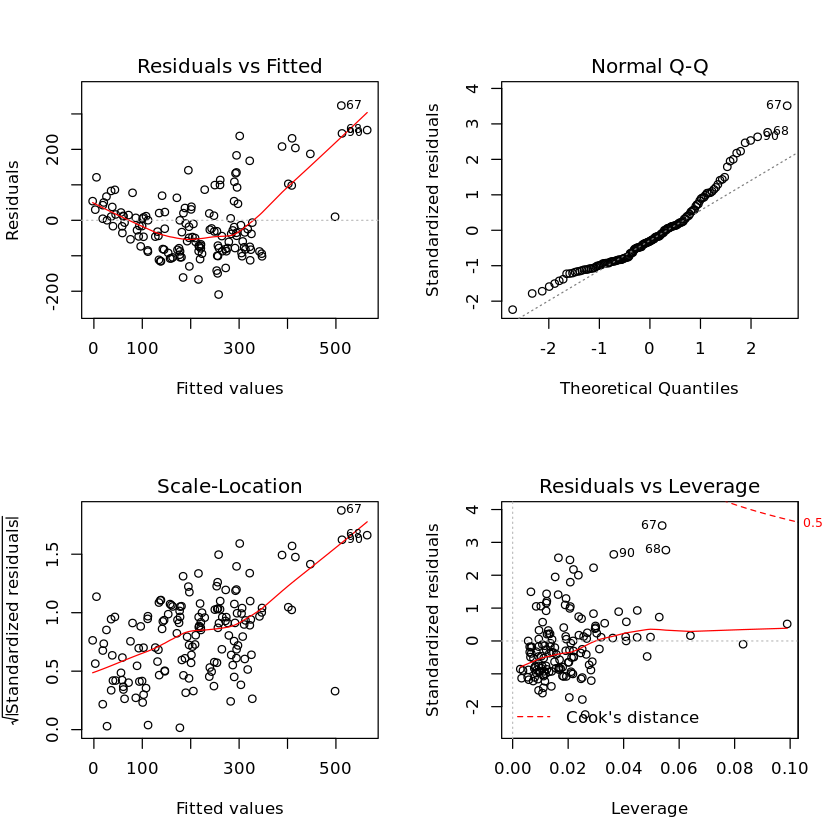

In [6]:
par(mfrow=c(2,2))
plot(lm3.fit)

This linear regression model is not perfect but it looks like a decent compromise of simplicity and fitness. In particular, the "residuals vs fitted" graph shows highly non-normal residuals at high values of the dependent variable.

### Adding features

The first equation shown above includes the influences that we assumed the most relevant to the energy consumption of the heat pump. The data may contain some additional explanatory variables, which may help predict $e_{hp}$ outside of this formalisation. For instance, the energy for DHW production $e_{dhw}$ and other uses $e_{other}$ indicate occupancy, which could be correlated to $e_{hp}$.

In [11]:
lm3.fit = lm(e_hp ~ tite + titg + i_sol + e_dhw + e_other + tits + 0, data=df)
summary(lm3.fit)


Call:
lm(formula = e_hp ~ tite + titg + i_sol + e_dhw + e_other + tits + 
    0, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-178.61  -53.30  -13.67   44.98  229.28 

Coefficients:
         Estimate Std. Error t value Pr(>|t|)    
tite     24.05832    1.71468  14.031  < 2e-16 ***
titg     22.01334    5.22600   4.212 4.42e-05 ***
i_sol     0.23192    0.17703   1.310    0.192    
e_dhw    -2.25056    0.45258  -4.973 1.84e-06 ***
e_other  -0.33178    0.08283  -4.006 9.85e-05 ***
tits    -13.08690    2.91482  -4.490 1.44e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 78.2 on 145 degrees of freedom
Multiple R-squared:  0.9102,	Adjusted R-squared:  0.9065 
F-statistic: 244.9 on 6 and 145 DF,  p-value: < 2.2e-16


Using the same indicators as before, it seems that the model has been improved again.